<a href="https://colab.research.google.com/github/marketpsych/marketpsych/blob/main/notebooks/v_USInflationForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the CPI result

This notebook gives an example of how RMAs can be used as exogenous variables in statistical models. In this specific example, we use the `inflationForecast` RMA for forecasting the headline inflation in the US.

---
## 1. Settings

### 1.1 Libraries
First, we need to install some libraries to obtain the Refinitiv MarketPsych Analytics (RMA) data directly into this notebook. If you need more details about downloading the data, please check out the [*i_introduction*](https://github.com/marketpsych/marketpsych/blob/main/notebooks/i_introduction.ipynb) notebook also provided on our [GitHub page](https://github.com/marketpsych/marketpsych).  

Additionally, some standard Python libraries are also necessary for running this example. If any of those libraries are not installed in your environment, please `pip install` them as:

```python
!{sys.executable} -m pip install libraryname
```

To install/load the relevant libraries please run the following cell.

In [1]:
############################ INSTALL PACKAGE ##########################
import sys
# Installs marketpsych library into your environment
!{sys.executable} -m pip install marketpsych --upgrade --quiet
!{sys.executable} -m pip install yfinance statsmodels --quiet

############################# LIBRARIES ###############################
from marketpsych import sftp
from matplotlib.ticker import PercentFormatter
from pandas.plotting import register_matplotlib_converters
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.statespace.sarimax import SARIMAX

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.2 Credentials

You need to provide your `userID` and ppk (or ssh) `key path` to access the RMA. Please adjust those two parameters in the below cell accordingly and then run the cell.

In [2]:
user = "8955490"
path_to_key = "./8955490.ppk" 

# Creates client object to connect with MarketPsych data
client = sftp.connect(user=user, key=path_to_key)

### 1.3 Loading the data

#### 1.3.1 RMA
Now you're ready to download the RMA (Refinitiv MarketPsych Analytics) data.
In this example, we'll use the `InflationForecast` RMA for the `US` from the Countries (`COU`) package. To simplify, we'll use the aggregated information from news only (`dataType == 'News'`). As we are attempting a monthly forecast, the lowest frequency data (`WDAI_UDAI`) is suitable for the purpose of this example.

After running the cell below, you should see a snippet of the dataframe.

In [3]:
%%time
########## INPUTS ########
trial      = False
assetClass = 'COU'
frequency  = 'WDAI_UDAI'
start_date = dt.datetime(1998, 1, 1) #yyyy-mm-dd
end_date   = dt.datetime.today()
dataTypes  = ('News',)
assetCodes = ('US',)

rma = client.download(
    trial       = trial,
    asset_class = sftp.AssetClass[assetClass],
    frequency   = sftp.Frequency[frequency],
    start       = start_date,
    end         = end_date,
    sources     = dataTypes,
    assets      = assetCodes
)
display(rma.head())

,id,assetCode,windowTimestamp,dataType,systemVersion,buzz,sentiment,negative,positive,optimism,...,flood,heatwave,humanInfectiousDisease,hunger,volcanicActivity,windStorm,diseaseBurden,humanDiseaseGI,humanDiseasePulm,futureVsPast
0,mp:1998-01-01_20.30.00.News.COU.US,US,1998-01-01 20:30:00+00:00,News,MP:4.0.0,6001.6,-0.087310,0.287007,0.199697,0.033241,...,NaN,NaN,0.000333,NaN,NaN,NaN,NaN,NaN,NaN,-0.390729
1,mp:1998-01-02_20.30.00.News.COU.US,US,1998-01-02 20:30:00+00:00,News,MP:4.0.0,10787.4,-0.021089,0.254973,0.233884,0.043801,...,NaN,NaN,0.001854,NaN,NaN,0.000464,NaN,0.000093,0.000371,-0.258070
2,mp:1998-01-03_20.30.00.News.COU.US,US,1998-01-03 20:30:00+00:00,News,MP:4.0.0,4756.7,-0.098493,0.298842,0.200349,0.045410,...,0.000841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001051,-0.321820
3,mp:1998-01-04_20.30.00.News.COU.US,US,1998-01-04 20:30:00+00:00,News,MP:4.0.0,6805.2,-0.061277,0.278684,0.217407,0.031006,...,NaN,NaN,0.001984,NaN,NaN,0.001176,0.000147,0.000147,0.000147,-0.314656
4,mp:1998-01-05_20.30.00.News.COU.US,US,1998-01-05 20:30:00+00:00,News,MP:4.0.0,13652.4,-0.039480,0.254571,0.215090,0.052408,...,0.000146,0.000073,0.000220,0.000146,NaN,0.000073,NaN,NaN,0.000293,-0.243745


CPU times: user 31.1 s, sys: 634 ms, total: 31.7 s
Wall time: 41.1 s


In [4]:
# Further inputs
agg_perd  = 'M' # Due to the frequency of cpi releases being on a monthly basis
rma_name  = 'inflationForecast'
buzz_name = 'buzz' 

# Converts the dates to datetime
rma['Date'] = pd.to_datetime(rma['windowTimestamp']).dt.date
rma.set_index('Date', drop=True, inplace=True)
rma.index = pd.to_datetime(rma.index, utc=None)

# Converts the series into a re-aggregated series
agg_rma = ((rma[rma_name] * rma[buzz_name]).resample(agg_perd).sum() \
/ rma[buzz_name].resample(agg_perd).sum()).rename(rma_name)

#### 1.3.2 Inflation Data 

We retrieve the publicly accessible CPI data from Federal Reserve Economic Data, the website can be found [here](https://fred.stlouisfed.org/).

In the original study we also used the change in oil prices as a second 
exogenous variable. This is obtained from Yahoo! Finance as the front-month futures.

In [5]:
start = '1998-01-01'
today = dt.datetime.today().strftime('%Y-%m-%d')
cpi_series_name = 'CPIAUCNS' # cpi data from All Urban Consumers Not Seasonal
wti_ticker = 'CL=F' 

# Retrieves inflation data
inflation = web.DataReader(cpi_series_name, 'fred', start=start, end=today)
# Makes adjustments to dates to pair with sentiment
inflation.resample(agg_perd).last
inflation.index += MonthEnd()
inflation_mom = inflation.pct_change()

# Retrieves crude oil price data
oil_price = yf.download(wti_ticker, start=start, end=today, progress=False)
oil_mom = oil_price.Close.resample(agg_perd).last().pct_change().rename(wti_ticker)

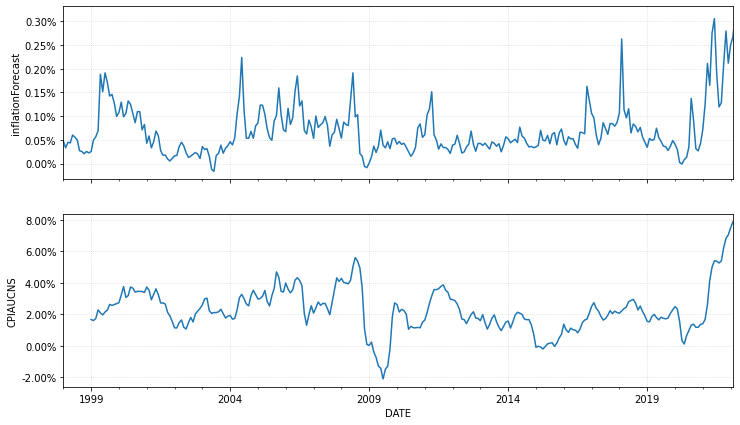

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

agg_rma[start_date:].plot(ax=ax1)
ax1.set_ylabel(rma_name)
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2))
ax1.grid(ls=":", alpha=0.5)

inflation[cpi_series_name][start_date:].pct_change(12).plot(ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2))
ax2.set_ylabel(cpi_series_name)
ax2.grid(ls=":", alpha=0.5)
plt.show()

## 2. Methodology

We use a simple SARIMAX model for the forecasting:

$C_{t+1} = \alpha + \gamma R_{t+1} + \beta O_{t+1} \phi C_t + \varphi C_{t-12} + \theta \epsilon_{t} + \epsilon_{t+1}$


where $C$ is the MoM (month-on-month) CPI, $R$ is the inflationForecast RMA and $O$ is the MoM change in the price of crude oil (WTI). Note that the choice of parameters in the SARIMAX model is to keep the model parsimonious. We did not try optimizing it, as is not in the scope of this simple analysis.

In [7]:
# Combines all data into a single dataframe 
data = pd.concat([agg_rma, inflation_mom, oil_mom], axis=1)
data = data[start:]
display(data.tail())

,inflationForecast,CPIAUCNS,CL=F
2021-11-30,0.002797,0.004913,-0.208089
2021-12-31,0.002119,0.003073,0.136446
2022-01-31,0.002504,0.008415,0.172052
2022-02-28,0.002678,0.009134,0.085876
2022-03-31,0.003153,NaN,0.089010


## 3. Modelling

Next, we run the model.

In [8]:
# Model inputs
order = (1, 0, 1)
trend = 'c'
freq  = 'M'
seasonal_order = (1, 0, 1, 12)
maxiter = 200
method = 'Powell'

# Last available inflation point
last_point = inflation_mom.dropna().index[-1]
next_point = last_point + MonthEnd()
# Creates endogenous and exogenous series
endog = data[cpi_series_name][:last_point]
exog  = data[[rma_name , wti_ticker]].fillna(0)
exog_is = exog[:last_point]
exog_os = np.array(exog.loc[next_point]).reshape(1, -1)

# Creates model
model = SARIMAX(order=order, trend=trend, freq=freq,
                    seasonal_order=seasonal_order, 
                    endog=endog, exog=exog_is)
# Fitting
fit = model.fit(disp=False, maxiter=maxiter, method=method)

display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           CPIAUCNS   No. Observations:                  290
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                1306.051
Date:                            Wed, 30 Mar 2022   AIC                          -2596.102
Time:                                    12:31:58   BIC                          -2566.743
Sample:                                01-31-1998   HQIC                         -2584.339
                                     - 02-28-2022                                         
Covariance Type:                              opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept          2.644e-06   1.16e-05      0.227      0.820   -2.01e-05    2.54e-05
inflationForecast     2.3253      0.398      5.841      0.000       1.545       3.106
CL=F                  0.0036      0.001      2.472      0.013       0.001       0.006
ar.L1                -0.0136      0.152     -0.089      0.929      -0.312       0.285
ma.L1                 0.3753      0.130      2.884      0.004       0.120       0.630
ar.S.L12              0.9872      0.023     43.022      0.000       0.942       1.032
ma.S.L12             -0.9041      0.088    -10.329      0.000      -1.076      -0.733
sigma2             6.701e-06   5.11e-07     13.119      0.000     5.7e-06     7.7e-06
===================================================================================
Ljung-Box (Q):                       57.64   Jarque-Bera (JB):               126.56
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.68
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. Forecasting

Below we show the results for the forecast of the CPI for the following month (in principle, it'll always use the last available point as baseline if run as it as).

In [9]:
result = fit.get_forecast(next_point, exog=exog_os)

last = inflation.iloc[-1].values[0]
fcst = (1+result.predicted_mean.values[0]) * inflation.iloc[-1].values[0]
mom  = result.predicted_mean.values[0]
yoy_sr = ((endog.append(result.predicted_mean) + 1).rolling(12).apply(np.prod) - 1).rename(cpi_series_name)
yoy  = yoy_sr.values[-1]
ci   = result.conf_int(0.05)
se   = result.se_mean.values[0]

print(f"{cpi_series_name} forecast for {next_point.strftime('%b-%Y')}")
print('-'*30)
print(f'Last: {last:.2f}')
print(f'Fcst: {fcst:.2f}')
print(f'MoM: {mom:.2%}')
print(f'YoY: {yoy:.2%}')

print()
print('Other stats:')
print('-'*30)
print(f'Standard error: {se:.2%}')
print(f'95% Interval: {ci[f"lower {cpi_series_name}"].values[0]:.2%} - {ci[f"upper {cpi_series_name}"].values[0]:.2%}')

# Print statements do not appear in the preview, so we also display a DF
display(
    pd.DataFrame([{
      'Date': next_point,
      'Last': last,
      'Forecast': fcst, 
      'MoM':mom*100,
      'YoY':yoy*100}],
      index=[cpi_series_name]).round(2).transpose()
      )

fig = px.line(yoy_sr.dropna().iloc[:-1], title='YoY US CPI')
fig.update_layout(yaxis= {'tickformat':',.1%'})
fig.add_trace(go.Scatter(
    x=[yoy_sr.index[-1]],
    y=[yoy_sr.values[-1]],
    mode='markers',
    marker=dict(size=15),
    name='Forecast'
))
fig.show()

CPIAUCNS forecast for Mar-2022
------------------------------
Last: 283.72
Fcst: 286.68
MoM: 1.04%
YoY: 8.23%

Other stats:
------------------------------
Standard error: 0.26%
95% Interval: 0.54% - 1.55%


,CPIAUCNS
Date,2022-03-31 00:00:00
Last,283.72
Forecast,286.68
MoM,1.04
YoY,8.23
